# Normalisierung von Bildern
Dieses Jupyter Notebook befasst sich mit der Normalisierung von Bildern. Es werden die Gründe für verschiedene Möglichkeiten aufgezählt und diese anhand von Codebeispielen erläutert.

## Basiscode
Im ersten Schritt werden hilfreiche Bibliotheken eingebunden. Dazu zählt **NumPy** für effiziente Matrizenberechnungen, der <a>MNIST</a>-Datensatz mit Beispielbildern aus **Keras** und **Matplotlib** zum Anzeigen der Bilder

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data
%matplotlib inline

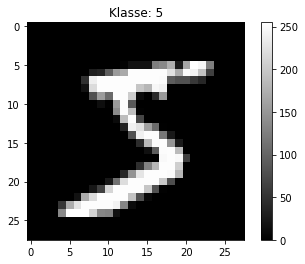

In [13]:
# Herunterladen des MNIST-Datensatzes
(x_train, y_train), (x_test, y_test) = load_data()
# Anzeigen eines Beispielbildes
idx = 0
im = x_train[idx] # Das Beispielbild
plt.clf() # Vorhandene Grafik löschen
plt.imshow(im, cmap="gray") # Bild zur Grafik hinzufügen
plt.colorbar() # Rechts die Farbskala
plt.title("Klasse: " + str(y_train[idx])) # Titel hinzufügen
plt.show() # Neue Grafik anzeigen

# Original und normalisierte Bilder anzeigen
def bilderAnzeigen(orig, norm):
    plt.clf()
    fig, ax = plt.subplots(1,2,figsize=(10,3)) # Bilder nebeneinander anzeigen
    # Zuerst das Originalbild
    original = ax[0].imshow(orig, cmap="gray")
    ax[0].set_title("Original")
    fig.colorbar(original, ax=ax[0])
    # Dann die neue Version
    normImage = ax[1].imshow(norm, cmap="gray")
    fig.colorbar(normImage, ax=ax[1])
    ax[1].set_title("Neu")
    plt.show()

## Skalierung der Bilder
### Grund
<div style="width:70%;margin:auto">
<img src="assets/CNN.jpeg" alt="Aufbau eines CNNs"/>
<small style="text-align:right;display:block"><a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">Quelle</a></small>
    <div style="text-align:center;color:RGB(117,117,117)">Aufbau eines Convolutional Neural Networks</div>
</div>
Alle Bilder eines Datensatzes müssen das gleiche Format haben. Das kann man aus der Abbildung oben entnehmen. Da am Ende der Konvolution ein vollständig verbundenes neuronales Netzwerk steht, welches eine fixe Anzahl an Knoten besitzt, müssen die als Input verwendeten Bilder ebenfalls eine fixe, durch das Gesamt-Netzwerk bestimmte Größe besitzen. Zwar sorgen die Konvolutions-Schichten dafür, dass die Pixelanzahl abnimmt, dieser Faktor ist aber konstant, d. h. es gibt keine Toleranz bei den Dimensionen der Bilder.<br>
Der folgende Code skaliert die Bilder. Rechts wird das Bild mit den neuen Dimensionen angezeigt.

<Figure size 432x288 with 0 Axes>

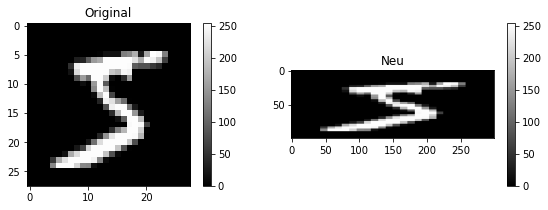

In [9]:
def skalierenDimensionen(xNeu, yNeu):
    # neues Array erstellen
    neu = np.zeros((xNeu, yNeu))
    # Skalieren (via Backward transform)
    faktorX = float(xNeu) / float(im.shape[0])
    faktorY = float(yNeu) / float(im.shape[1])
    for x in range(xNeu):
        for y in range(yNeu):
            # simpelste Skalierung, der nächstkleinere Pixel wird bei Float-Werten genommen
            neu[x][y] = im[int(x/faktorX)][int(y/faktorY)]
    return neu

neu = skalierenDimensionen(100, 300)
bilderAnzeigen(im, neu)

## Skalierung der Pixelwerte
### Grund
Bei dieser Form der Skalierung werden alle Pixelwerte auf den Bereich $[0;1]$ (bzw. $[-1;1]$) eingeschränkt. Das bedeutet einerseits, dass das CNN Bilder mit beliebig vielen Abstufungen einer Farbe verarbeiten kann. Mit Farbabstufungen ist hier die Größe eines Farbkanals gemeint, auch Bittiefe genannt (Alltagskameras speichern 8 Bit pro Farbe, d. h. Werte von $0$ bis $255$, während wissenschaftliche Kameras eine Bittiefe von 16 Bit haben, also $65536$ verschiedene Nuancen pro Farbkanal unterscheiden). Andererseits sind neuronale Netze und deren Komponenten oft dafür optimiert, dass sie mit Parametern in diesem Größenbereich schneller zu einer Lösung konvergieren. Die Skalierung sorgt also für eine kürzere Trainingszeit des Netzwerks.
### Das Verfahren
#### Skalierung auf $[0;1]$
Die Skalierung auf $[0;1]$ erfolgt trivial durch die Division jedes Pixels durch den maximalen Pixelwert. Die Formel dafür lautet $$x_{norm}=\frac{x}{2^b-1}$$ mit $b$ als Bittiefe. Anders ausgedrückt wird z. B. bei 8 Bit pro Farbkanal (Division durch $2^8-1=255$) der Pixel mit dem Wert RGB(0, 128, 255) zu dem Wert RGB(0, 0.5, 1).<br>
In folgendem Codebeispiel kann man erkennen, dass der Zahlenbereich von $[0;255]$ auf $[0;1]$ gemappt wird.

<Figure size 432x288 with 0 Axes>

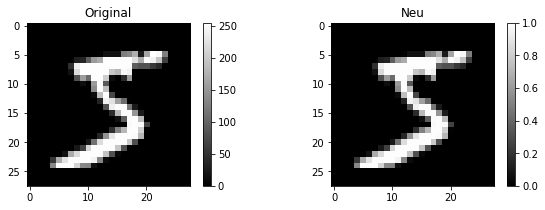

In [10]:
def skalierung0_1(x, b):
    # Funktioniert mit einzelnen Pixeln, aber auch mit NumPy Arrays
    return x / (2**b - 1)

bilderAnzeigen(im, skalierung0_1(im, 8))

#### Skalierung auf $[-1;1]$
Um alle Pixelwerte auf den Bereich $[-1;1]$ zu skalieren, wird die Formel $$x_{norm}=\frac{x-m}{x_{max}-x_{min}}$$ mit dem arithmetischen Mittel (mean) $m$ und dem höchsten bzw. niedrigsten Wert des Bildes $x_{max}$ bzw. $x_{min}$ auf jedes Bild einzeln angewandt. Alternative Implementierungen nutzen sogenannte "Batches", d.h. eine Gruppe von Bildern, die zur Berechnung des means, des Maximums und des Minimums hergenommen werden.<br>
Der folgende Code hat exakt diese Funktionsweise.

<Figure size 432x288 with 0 Axes>

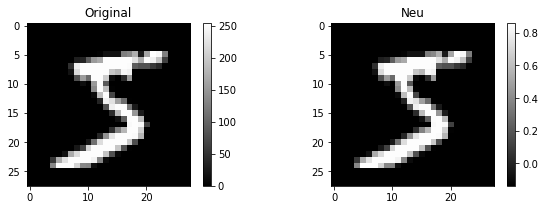

In [11]:
def skalierungMinus1_1(x):
    mean = np.mean(x)
    maxVal = np.max(x)
    minVal = np.min(x)
    return (x - mean)/(maxVal - minVal)

bilderAnzeigen(im, skalierungMinus1_1(im))

Eine weitere, oft genutzte Formel ist $$x_{norm}=\frac{x-m}{s}$$ wieder mit dem mean $m$, dazu die Standardabweichung $s$. In diesem Fall wird die Verteilung der Pixel auf eine Normalverteilung abgebildet. Das führt wie schon oben dazu, dass das CNN kürzer trainiert werden muss. Grund dafür ist, dass neuronale Netze so ausgelegt sind, dass sie bei einer Normalverteilung der Features, d. h. der Inputwerte &ndash; in unserem Fall Pixelwerte &ndash; möglichst schnell konvergieren.
<div class="alert alert-warning">Im letzten Fall liegen ca. 68% der Werte im Intervall $[-1;1]$ (vgl. <a href="https://de.wikipedia.org/w/index.php?title=Normalverteilung&oldid=205154928">Wikipedia</a>). Dennoch besitzen alle Werte &ndash; ausgenommen Ausreißer &ndash; die Größenordnung $1$, was für ein neuronales Netz vollständig ausreichend ist. Zusammen mit dem Fakt, dass die Eingabewerte nach der Umformung normalverteilt sind (Mean: $0$, Standardabweichung: $1$), sorgt dies für eine Verkürzung der Trainingsdauer</div>
Es folgt wieder ein Codeausschnitt. Unter den Bildern steht jeweils der Mean und die Standardabweichung. Der Anteil im Intervall $[-1;1]$ ist nicht $68\%$, weil die Bilder fast ausschließlich aus schwarzen und weißen Pixeln bestehen. Für andere Bilder ist dieser Anteil näher am theoretischen Wert.

<Figure size 432x288 with 0 Axes>

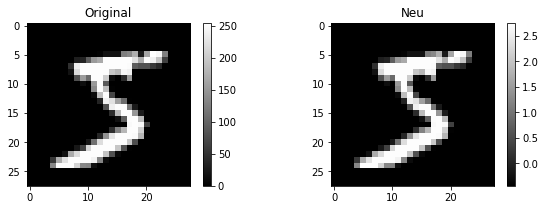

Original Mean: 35.108418367346935, Normalisiert Mean: 7.250436079184695e-17
Original Standardabweichung: 79.64882892760731, Normalisiert Standardabweichung: 1.0
Anteil zwischen -1 und 1: 0.85


In [12]:
def skalierungMean0(x):
    mean = np.mean(x)
    std = np.std(x)
    return (x - mean)/std

norm = skalierungMean0(im)
bilderAnzeigen(im, norm)

# Metadaten über die Bilder
print(f"Original Mean: {np.mean(im)}, Normalisiert Mean: {np.mean(norm)}")
print(f"Original Standardabweichung: {np.std(im)}, Normalisiert Standardabweichung: {np.std(norm)}")
print("Anteil zwischen -1 und 1: %.2f" % (((-1 < norm) & (norm < 1)).sum()/norm.size))